In [2]:
import librosa
import librosa.display
import os
import pickle
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import re
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.under_sampling import RandomUnderSampler
from tqdm import tqdm
import statistics

import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

## Loading Paths

In [3]:
emotions = ['disgust', 'fear', 'happy', 'neutral', 'sad']

In [4]:
paths = []
names = []
for emotion in emotions:
    audios = os.listdir('dataset/train/'+emotion)
    if len(audios) > 300:
        audios = audios[:300]
    for audio in audios:
        paths.append('dataset/train/'+emotion+'/'+audio)
        names.append(emotion)

{'happy': 300, 'neutral': 300, 'sad': 300, 'disgust': 226, 'fear': 210}


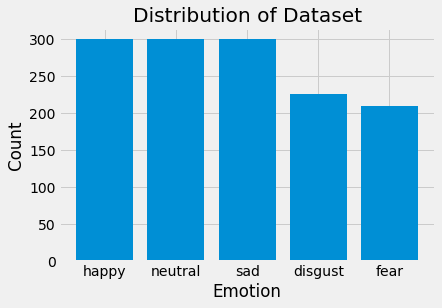

In [5]:
counts = dict(pd.DataFrame(names, columns=['names'])['names'].value_counts())
print(counts)
x = list(counts.keys())
y = list(counts.values())
x_pos = [i for i, _ in enumerate(x)]
plt.bar(x_pos, y)
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of Dataset')
plt.xticks(x_pos, x)
plt.show()

## Audio Length Analysis

Minimum length is  0.064
Maximum length is  235.072
Average length is  3.575537050898206


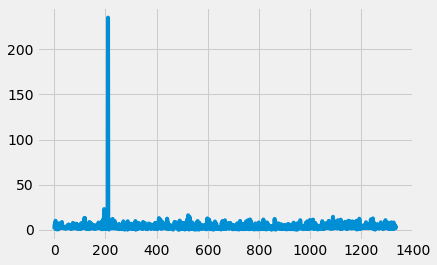

In [6]:
lengths = []
for index,path in enumerate(paths):
    length = librosa.get_duration(filename=path)
    lengths.append(length)
print("Minimum length is ", min(lengths))
print("Maximum length is ", max(lengths))
print("Average length is ", sum(lengths)/len(lengths))
plt.plot(lengths)

## Loading Audios

In [7]:
ref = pd.DataFrame(names, columns=['label'])
ref = pd.concat([ref, pd.DataFrame(paths, columns=['path'])], axis=1)
ref.head()

,label,path
0,disgust,dataset/train/disgust/MEL_dia415_utt0_negative...
1,disgust,dataset/train/disgust/MEL_dia231_utt10_negativ...
2,disgust,dataset/train/disgust/MEL_dia169_utt18_negativ...
3,disgust,dataset/train/disgust/MEL_dia754_utt1_negative...
4,disgust,dataset/train/disgust/MEL_dia151_utt0_negative...


In [33]:
df = pd.DataFrame(columns=['feature'])
count = 0

for i in tqdm(ref['path']):
    
    X, sample_rate = librosa.load(i,res_type='kaiser_fast')
    
    # MFCC features
    mfccs = librosa.feature.mfcc(y=X,sr=np.array(sample_rate),n_mfcc=13).T
    means = np.mean(mfccs, axis=0)
    stds = np.std(mfccs, axis=0)
    mins = np.min(mfccs, axis=0)
    maxs = np.max(mfccs, axis=0)
    
    features = np.hstack([means, stds, mins, maxs])
                         
    df.loc[count] = [features]
    count += 1

df.head()

100%|██████████| 1336/1336 [00:47<00:00, 28.10it/s]


,feature
0,"[-337.7072, 163.94087, -31.621784, 46.491993, ..."
1,"[-334.57117, 114.641014, -50.600487, 60.781746..."
2,"[-291.3202, 133.70479, -26.424326, 43.450256, ..."
3,"[-418.32623, 109.08304, -34.161945, 51.483124,..."
4,"[-169.5616, 177.97887, -100.10902, 47.94595, -..."


In [34]:
df = pd.concat([ref,pd.DataFrame(df['feature'].values.tolist())], axis=1)
print(df.shape)

(1336, 54)


In [35]:
df = df.fillna(0)
df.head()

,label,path,0,1,2,3,4,5,6,7,...,42,43,44,45,46,47,48,49,50,51
0,disgust,dataset/train/disgust/MEL_dia415_utt0_negative...,-337.707214,163.940872,-31.621784,46.491993,-33.155056,21.786509,-9.836021,-7.950692,...,82.693031,-10.516897,52.794006,3.358495,11.405487,13.988308,15.532568,22.207924,0.571427,19.867054
1,disgust,dataset/train/disgust/MEL_dia231_utt10_negativ...,-334.571167,114.641014,-50.600487,60.781746,-43.640293,3.757033,-15.749180,-7.995167,...,189.778107,16.718452,83.206207,44.142384,33.977135,25.532639,29.811821,27.791262,12.426098,40.292953
2,disgust,dataset/train/disgust/MEL_dia169_utt18_negativ...,-291.320190,133.704788,-26.424326,43.450256,-33.509495,23.301908,-7.277973,7.967053,...,122.112572,11.894715,85.790939,25.608952,45.185379,32.224251,14.907877,42.756218,13.411173,29.019520
3,disgust,dataset/train/disgust/MEL_dia754_utt1_negative...,-418.326233,109.083038,-34.161945,51.483124,-30.757301,8.589872,-19.528963,-4.560179,...,104.548645,0.776099,62.711899,9.476995,38.993675,21.421082,1.973741,13.989029,1.971203,17.393919
4,disgust,dataset/train/disgust/MEL_dia151_utt0_negative...,-169.561600,177.978867,-100.109016,47.945950,-51.487225,17.913237,-25.129881,-5.753327,...,69.099190,-39.603264,35.160294,-8.618310,10.617272,6.320773,7.883181,20.720394,-0.352820,11.976385


In [36]:
X = df.drop(['label', 'path'], axis=1)
y = df['label']

In [37]:
X = np.array(X)
y = np.array(y)

In [38]:
lb = LabelEncoder()
y = np_utils.to_categorical(lb.fit_transform(y))

In [39]:
print(X.shape)
print(y.shape)

(1336, 52)
(1336, 5)


In [40]:
with open('X_train_4.pkl', 'wb') as f:
    pickle.dump(X, f)

In [41]:
with open('y_train_4.pkl', 'wb') as f:
    pickle.dump(y, f)

## Validation Data

In [42]:
val_paths = []
val_names = []
for emotion in emotions:
    audios = os.listdir('dataset/val/'+emotion)
    for audio in audios:
        val_paths.append('dataset/val/'+emotion+'/'+audio)
        val_names.append(emotion)

{'neutral': 441, 'happy': 179, 'sad': 78, 'disgust': 26, 'fear': 25}


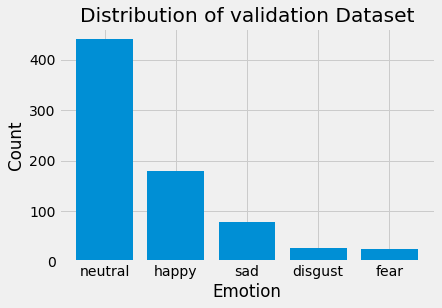

In [43]:
val_counts = dict(pd.DataFrame(val_names, columns=['names'])['names'].value_counts())
print(val_counts)
x = list(val_counts.keys())
y = list(val_counts.values())
x_pos = [i for i, _ in enumerate(x)]
plt.bar(x_pos, y)
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of validation Dataset')
plt.xticks(x_pos, x)
plt.show()

In [44]:
val_ref = pd.DataFrame(val_names, columns=['label'])
val_ref = pd.concat([val_ref, pd.DataFrame(val_paths, columns=['path'])], axis=1)
val_ref.head()

,label,path
0,disgust,dataset/val/disgust/MEL_dia40_utt2_negative_DI...
1,disgust,dataset/val/disgust/MEL_dia92_utt5_negative_DI...
2,disgust,dataset/val/disgust/MEL_dia85_utt4_negative_DI...
3,disgust,dataset/val/disgust/MEL_dia15_utt7_negative_DI...
4,disgust,dataset/val/disgust/MEL_dia23_utt6_negative_DI...


In [45]:
val_df = pd.DataFrame(columns=['feature'])
count = 0

for i in tqdm(val_ref['path']):
    X, sample_rate = librosa.load(i,res_type='kaiser_fast')
    
    # MFCC features
    mfccs = librosa.feature.mfcc(y=X,sr=np.array(sample_rate),n_mfcc=13).T
    means = np.mean(mfccs, axis=0)
    stds = np.std(mfccs, axis=0)
    mins = np.min(mfccs, axis=0)
    maxs = np.max(mfccs, axis=0)
    
    features = np.hstack([means, stds, mins, maxs])
                         
    val_df.loc[count] = [features]
    count += 1

val_df.head()

100%|██████████| 749/749 [00:24<00:00, 30.00it/s]


,feature
0,"[-195.89957, 144.90457, -64.324844, 48.661957,..."
1,"[-253.54207, 121.09179, -123.014824, 43.423832..."
2,"[-319.45514, 135.5291, -67.46118, 44.43687, -3..."
3,"[-414.5938, 111.512566, -42.20316, 58.00162, -..."
4,"[-420.396, 115.90984, -59.94758, 35.07802, -19..."


In [46]:
val_df = pd.concat([val_ref,pd.DataFrame(val_df['feature'].values.tolist())], axis=1)
print(val_df.shape)

(749, 54)


In [47]:
val_df = val_df.fillna(0)

In [48]:
X_val = np.array(val_df.drop(['label', 'path'], axis=1))
y_val = np.array(val_df['label'])

In [49]:
lb = LabelEncoder()
with open('labels', 'rb') as f:
    lb = pickle.load(f)

In [50]:
y_val = np_utils.to_categorical(lb.transform(y_val))

In [51]:
print(X_val.shape)
print(y_val.shape)

(749, 52)
(749, 5)


In [52]:
with open('X_val_4.pkl', 'wb') as f:
    pickle.dump(X_val, f)

In [53]:
with open('y_val_4.pkl', 'wb') as f:
    pickle.dump(y_val, f)